# RNN
### Junfei Liu

In [71]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmetrics.functional import accuracy
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

## Preprocessing

In [72]:
df= pd.read_csv('../forecasting_case_study.csv')
df = df[df['Sales'] != 0]
df.reset_index(drop=True, inplace=True)
df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df['date']=df['date'] - df['date'].min() + 1
print(df.info())

products = df['Product'].unique()

#create a data frame dictionary to store your data frames for different products
DataFrameDict = {elem : pd.DataFrame() for elem in products}

for key in DataFrameDict.keys():
    df_temp = df[:][df['Product'] == key]
    DataFrameDict[key] = df_temp.drop(['Product'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1188 non-null   object 
 1   date                1188 non-null   int64  
 2   Sales               1188 non-null   int64  
 3   Price Discount (%)  1188 non-null   float64
 4   In-Store Promo      1188 non-null   int64  
 5   Catalogue Promo     1188 non-null   int64  
 6   Store End Promo     1188 non-null   int64  
 7   Google_Mobility     1188 non-null   float64
 8   Covid_Flag          1188 non-null   int64  
 9   V_DAY               1188 non-null   int64  
 10  EASTER              1188 non-null   int64  
 11  CHRISTMAS           1188 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 111.5+ KB
None


In [73]:
drop_enc = LabelBinarizer()
drop_enc.fit(df['Product'])
encoded = drop_enc.transform(df['Product'])
df.drop("Product", axis=1, inplace=True)
ohe_df = pd.DataFrame(encoded, columns=['SKU1','SKU2','SKU3','SKU4','SKU5','SKU6'])
df = pd.concat([df, ohe_df], axis=1)


df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df['date']=df['date'] - df['date'].min() + 1
df = df.set_index(['date'])
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
    
# 90% cap sales
# y = df['Sales']
# ninetieth_percentile = np.percentile(y, 90)
# df.loc[df['Sales'] > ninetieth_percentile] = ninetieth_percentile

# y = df['Sales']
# y_mean = y.mean()
# y_std = y.std()
# y_normalized = (y-y_mean)/y_std
# df['Sales'] = y_normalized

df['Sales'] = [np.log(x) for x in df['Sales']]

# plt.figure(figsize=(16,4))
# #Histogram
# plt.subplot(1,2,1)
# plt.hist(y_capping, alpha=0.5)
# #boxplot
# plt.subplot(1,2,2)
# sns.boxplot(y_capping, orient="h")
# plt.show

print(df.head())

          Sales  Price Discount (%)  In-Store Promo  Catalogue Promo  \
date                                                                   
1     10.230991                 0.0               0                0   
1     10.275844                 0.0               1                0   
1     10.728321                17.0               0                0   
1     10.195747                 0.0               1                0   
1     10.645401                17.0               0                0   

      Store End Promo  Google_Mobility  Covid_Flag  V_DAY  EASTER  CHRISTMAS  \
date                                                                           
1                   0              0.0           0      0       0          0   
1                   1              0.0           0      1       0          0   
1                   0              0.0           0      0       0          0   
1                   1              0.0           0      0       0          0   
1              

In [74]:
def split_data(df, train_size=0.8, val_size=0.2, test_size=0.2, shuffle=True, drop_last=True):
    X = df.drop(columns=['Sales'])
    y = df[['Sales']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # val split?
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

    # scaler?
    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train)
    X_val_arr = scaler.transform(X_val)
    X_test_arr = scaler.transform(X_test)

    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)

    # data loader
    train_features = torch.Tensor(X_train_arr)
    train_targets = torch.Tensor(y_train_arr)
    val_features = torch.Tensor(X_val_arr)
    val_targets = torch.Tensor(y_val_arr)
    test_features = torch.Tensor(X_test_arr)
    test_targets = torch.Tensor(y_test_arr)

    train = TensorDataset(train_features, train_targets)
    val = TensorDataset(val_features, val_targets)
    test = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    
    return train_loader, val_loader, test_loader

## RNN, LSTM, GRU

In [75]:
class MyGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyGRU, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.gru(x, self.last_hidden)
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        #print(self.last_hidden.shape)
        
        return self.fc(output)

class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyLSTM, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.last_cell = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x, (self.last_hidden, self.last_cell))
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        self.last_cell = cell.data
        #print(self.last_hidden.shape)
        
        return self.fc(output)
    
class MyRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyRNN, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.rnn(x, self.last_hidden)
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        #print(self.last_hidden.shape)
        
        return self.fc(output)
    
def get_model(model, model_params):
    models = {
        "rnn": MyRNN,
        "lstm": MyLSTM,
        "gru": MyGRU,
    }
    return models.get(model.lower())(**model_params)

In [76]:

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
    
    
    def evaluate(self, test_loader, n_features, batch_size=64):

        with torch.no_grad():
            predictions = []
            values = []
            
            for x_test, y_test in test_loader:
                #print(next(iter(test_loader.dataset)))
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values
    
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()


Now training RNN with one-hot encoded product types...
[1/100] Training loss: 0.1204	 Validation loss: 0.0531
[2/100] Training loss: 0.0439	 Validation loss: 0.0395
[3/100] Training loss: 0.0329	 Validation loss: 0.0310
[4/100] Training loss: 0.0263	 Validation loss: 0.0248
[5/100] Training loss: 0.0193	 Validation loss: 0.0167
[6/100] Training loss: 0.0171	 Validation loss: 0.0152
[7/100] Training loss: 0.0172	 Validation loss: 0.0132
[8/100] Training loss: 0.0141	 Validation loss: 0.0148
[9/100] Training loss: 0.0139	 Validation loss: 0.0132
[10/100] Training loss: 0.0137	 Validation loss: 0.0119
[50/100] Training loss: 0.0090	 Validation loss: 0.0104
[100/100] Training loss: 0.0074	 Validation loss: 0.0092


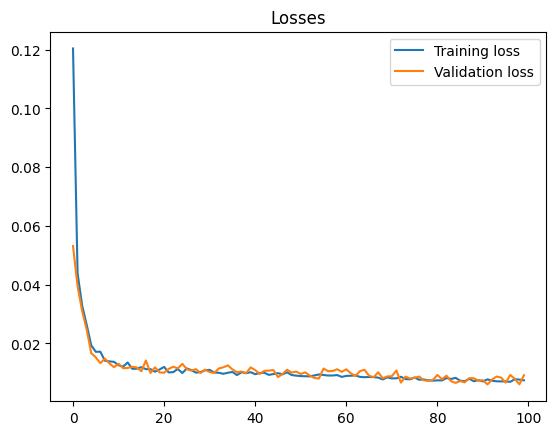

The MAPE value of RNN is 0.7252646684646606.

Now training LSTM...
[1/100] Training loss: 0.2217	 Validation loss: 0.0692
[2/100] Training loss: 0.0730	 Validation loss: 0.0487
[3/100] Training loss: 0.0628	 Validation loss: 0.0729
[4/100] Training loss: 0.0546	 Validation loss: 0.0445
[5/100] Training loss: 0.0520	 Validation loss: 0.0433
[6/100] Training loss: 0.0477	 Validation loss: 0.0540
[7/100] Training loss: 0.0439	 Validation loss: 0.0457
[8/100] Training loss: 0.0447	 Validation loss: 0.0468
[9/100] Training loss: 0.0416	 Validation loss: 0.0402
[10/100] Training loss: 0.0382	 Validation loss: 0.0370
[50/100] Training loss: 0.0073	 Validation loss: 0.0075
[100/100] Training loss: 0.0059	 Validation loss: 0.0048


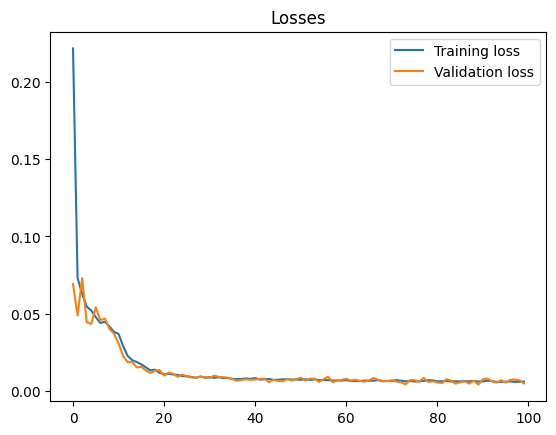

The MAPE value of LSTM is 0.8706681728363037.

Now training GRU...
[1/100] Training loss: 0.1010	 Validation loss: 0.0956
[2/100] Training loss: 0.0605	 Validation loss: 0.0551
[3/100] Training loss: 0.0549	 Validation loss: 0.0340
[4/100] Training loss: 0.0443	 Validation loss: 0.0348
[5/100] Training loss: 0.0401	 Validation loss: 0.0341
[6/100] Training loss: 0.0359	 Validation loss: 0.0267
[7/100] Training loss: 0.0298	 Validation loss: 0.0262
[8/100] Training loss: 0.0210	 Validation loss: 0.0119
[9/100] Training loss: 0.0159	 Validation loss: 0.0130
[10/100] Training loss: 0.0133	 Validation loss: 0.0098
[50/100] Training loss: 0.0067	 Validation loss: 0.0047
[100/100] Training loss: 0.0060	 Validation loss: 0.0047


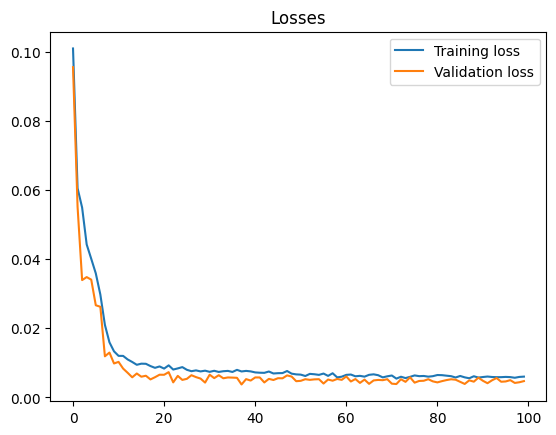

The MAPE value of GRU is 0.8571109175682068.



In [77]:
def train_model(model_name, df, model_params, input_dim, batch_size=64, n_epochs=100):
    train_loader, val_loader, test_loader = split_data(df)
    # print(next(iter(val_loader.dataset)))
    # print(next(iter(test_loader.dataset)))
    model = get_model(model_name, model_params)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = nn.MSELoss(reduction="mean")
    
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
    opt.plot_losses()

    predictions, values = opt.evaluate(test_loader, n_features=input_dim, batch_size=batch_size)
    accuracy = 1 - mean_absolute_percentage_error(values[0], predictions[0])
    print(f"The MAPE value of {model_name} is {accuracy}.\n")

def main():
    output_dim = 1
    hidden_dim = 64
    num_layers = 3
    batch_size = 64
    dropout = 0.2
    n_epochs = 100
    input_dim_all = len(df.columns)-1
    model_params_all = {'input_dim': input_dim_all,
                    'hidden_dim' : hidden_dim,
                    'num_layers' : num_layers,
                    'output_dim' : output_dim,
                    'batch_size' : batch_size,
                    'dropout_prob' : dropout}
    
    input_dim_product = len(DataFrameDict['SKU1'].columns)-1
    model_params_product = {'input_dim': input_dim_product,
                    'hidden_dim' : hidden_dim,
                    'num_layers' : num_layers,
                    'output_dim' : output_dim,
                    'batch_size' : batch_size,
                    'dropout_prob' : dropout}
    
    
    print("Now training RNN with one-hot encoded product types...")
    train_model('RNN', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training RNN with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('RNN', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)
    
    print("Now training LSTM...")
    train_model('LSTM', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training LSTM with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('LSTM', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)
    
    print("Now training GRU...")
    train_model('GRU', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training GRU with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('GRU', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)

main()